In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d mohammedalbrayh/images-for-saudi-arabia-landmarks --unzip -p /content/saudi_landmarks


Dataset URL: https://www.kaggle.com/datasets/mohammedalbrayh/images-for-saudi-arabia-landmarks
License(s): MIT
 99% 249M/252M [00:00<00:00, 500MB/s]
100% 252M/252M [00:00<00:00, 546MB/s]


In [4]:
!pip install faiss-cpu --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 29.8 MB/s eta 0:00:00


In [5]:
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import faiss
from transformers import CLIPProcessor, CLIPModel

images_dir = Path("/content/saudi_landmarks")
img_paths = list(images_dir.rglob("*.png")) + list(images_dir.rglob("*.jpg"))
print("Found", len(img_paths), "images")


Found 399 images


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [7]:
embs = []
meta = []
for p in img_paths:
    img = Image.open(p).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        e = model.get_image_features(**inputs).cpu().numpy().squeeze()
    embs.append(e)
    meta.append(p)
embs = np.stack(embs)

In [8]:
index = faiss.IndexFlatL2(embs.shape[1])
index.add(embs)
print("✅ FAISS index built")

✅ FAISS index built


In [9]:
query = "Diriyah"
q_inputs = processor(text=query, return_tensors="pt").to(device)
with torch.no_grad():
    q_emb = model.get_text_features(**q_inputs).cpu().numpy()
D, I = index.search(q_emb, k=5)

1. Diriyah / d2.png (distance=126.75)


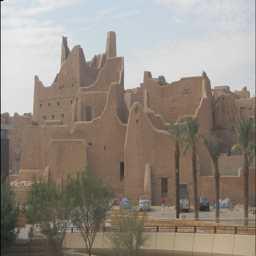

2. Diriyah / d11.png (distance=126.84)


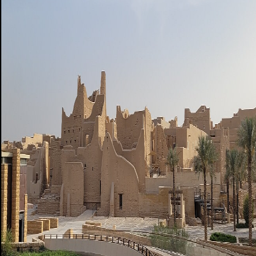

3. Ibrahim Palace / Screenshot 2023-11-16 095200.png (distance=127.03)


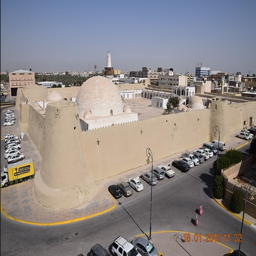

4. Al Masmak Palace / masmak (5).png (distance=129.80)


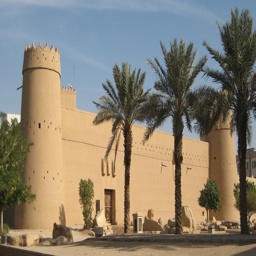

5. Diriyah / d3.png (distance=131.11)


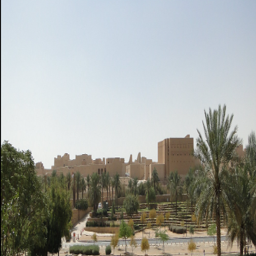

In [10]:
for rank, idx in enumerate(I[0]):
    print(f"{rank+1}. {meta[idx].parent.name} / {meta[idx].name} (distance={D[0][rank]:.2f})")
    display(Image.open(meta[idx]).resize((256,256)))

Top-5 landmarks similar to 'The Clock Towers':
1. The Clock Towers / watch (4).png (distance=136.14)


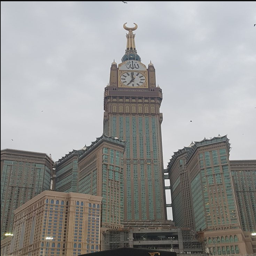

2. The Clock Towers / watch (7).png (distance=136.34)


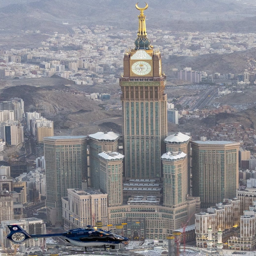

3. The Clock Towers / watch (16).png (distance=138.53)


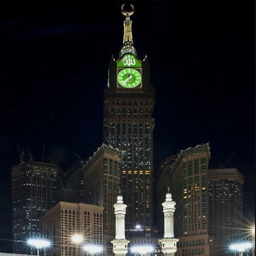

In [11]:
query = "The Clock Towers"
q_inputs = processor(text=query, return_tensors="pt").to(device)

with torch.no_grad():
    q_emb = model.get_text_features(**q_inputs).cpu().numpy()

D, I = index.search(q_emb, k=3)

print(f"Top-5 landmarks similar to '{query}':")
for rank, idx in enumerate(I[0]):
    print(f"{rank+1}. {meta[idx].parent.name} / {meta[idx].name} (distance={D[0][rank]:.2f})")
    display(Image.open(meta[idx]).resize((256, 256)))

In [15]:
import json
from pathlib import Path

landmark_folders = [
    "The Kaaba",
    "Jabal AlFil (Elephant Rock)",
    "Kingdom Tower",
    "Ibrahim Palace",
    "Al Masmak Palace",
    "Al Rahmah Mosque",
    "Diriyah",
    "King Abdullah Financial District (KAFD)",
    "Maraya",
    "Nassif House Museum",
    "Riyadh Water Tower"
]

descriptions = {
    "The Kaaba": (
        "The Kaaba is a cuboid structure located inside the Masjid al-Haram in Mecca. "
        "It is the most sacred site in Islam and the direction (qibla) Muslims face during prayer.",
        [
            ("What shape is the Kaaba?", "cuboid", 16),
            ("Where is the Kaaba located?", "Masjid al-Haram in Mecca", 43),
            ("What is the Kaaba's significance in Islam?", "the most sacred site in Islam", 71)
        ]
    ),
    "Jabal AlFil (Elephant Rock)": (
        "Jabal AlFil, also known as Elephant Rock, is a natural rock formation in AlUla, Saudi Arabia. "
        "It resembles an elephant with a trunk touching the ground and is a popular tourist attraction.",
        [
            ("What is another name for Jabal AlFil?", "Elephant Rock", 25),
            ("Where is Jabal AlFil located?", "AlUla, Saudi Arabia", 72),
            ("Why is it called Elephant Rock?", "resembles an elephant with a trunk", 101)
        ]
    ),
    "Kingdom Tower": (
        "The Kingdom Tower is a skyscraper in Riyadh. It is one of the most iconic buildings in Saudi Arabia and features a skybridge with panoramic views.",
        [
            ("Where is Kingdom Tower located?", "Riyadh", 43),
            ("What does Kingdom Tower feature?", "a skybridge with panoramic views", 113)
        ]
    ),
    "Ibrahim Palace": (
        "Ibrahim Palace is a historical fort located in Al-Ahsa. It combines Islamic and military architectural styles and served as a government center during the Ottoman era.",
        [
            ("What type of architecture is seen in Ibrahim Palace?", "Islamic and military", 63),
            ("What was Ibrahim Palace used for?", "government center during the Ottoman era", 109)
        ]
    ),
    "Al Masmak Palace": (
        "Al Masmak Palace is a clay and mud-brick fort in Riyadh. It played a significant role in the unification of Saudi Arabia in the early 20th century.",
        [
            ("What material is Al Masmak Palace built from?", "clay and mud-brick", 36),
            ("Why is Al Masmak Palace historically important?", "significant role in the unification of Saudi Arabia", 74)
        ]
    ),
    "Al Rahmah Mosque": (
        "Al Rahmah Mosque is located in Jeddah, on the coast of the Red Sea. It is often called the Floating Mosque due to its structure over the water.",
        [
            ("Where is Al Rahmah Mosque located?", "Jeddah", 34),
            ("Why is Al Rahmah Mosque called the Floating Mosque?", "its structure over the water", 106)
        ]
    ),
    "Diriyah": (
        "Diriyah is a historic town in Saudi Arabia, recognized as a UNESCO World Heritage Site. It was the original home of the Saudi royal family and features traditional Najdi architecture.",
        [
            ("What is Diriyah recognized as?", "a UNESCO World Heritage Site", 52),
            ("What architectural style is found in Diriyah?", "Najdi architecture", 144)
        ]
    ),
    "King Abdullah Financial District (KAFD)": (
        "The King Abdullah Financial District is a business hub in Riyadh, known for its modern skyscrapers, eco-friendly buildings, and financial institutions.",
        [
            ("Where is the KAFD located?", "Riyadh", 52),
            ("What is KAFD known for?", "modern skyscrapers, eco-friendly buildings, and financial institutions", 67)
        ]
    ),
    "Maraya": (
        "Maraya is the world's largest mirrored building, located in the AlUla desert. It reflects the surrounding landscape and is used for concerts and cultural events.",
        [
            ("What makes Maraya unique?", "the world's largest mirrored building", 13),
            ("Where is Maraya located?", "AlUla desert", 58),
            ("What is Maraya used for?", "concerts and cultural events", 125)
        ]
    ),
    "Nassif House Museum": (
        "Nassif House Museum is a historical building in Jeddah’s Al-Balad district. It served as a royal guesthouse and features traditional Hijazi architecture.",
        [
            ("Where is Nassif House Museum located?", "Jeddah’s Al-Balad district", 47),
            ("What kind of architecture does Nassif House feature?", "Hijazi architecture", 121)
        ]
    ),
    "Riyadh Water Tower": (
        "The Riyadh Water Tower is a landmark structure in the city of Riyadh. It provides water storage and offers panoramic views from its upper levels.",
        [
            ("What is the function of Riyadh Water Tower?", "water storage", 72),
            ("What feature does the top of the tower offer?", "panoramic views", 103)
        ]
    )
}

squad_data = {"data": []}

for title, (context, qas_list) in descriptions.items():
    paragraph = {
        "context": context,
        "qas": [
            {
                "id": f"{title[:10]}_{i+1}",
                "question": q,
                "answers": [{"text": a, "answer_start": s}]
            }
            for i, (q, a, s) in enumerate(qas_list)
        ]
    }
    squad_data["data"].append({"title": title, "paragraphs": [paragraph]})
output_path = "/content/saudi_landmarks_qa.json"

with open(output_path, "w") as f:
    json.dump(squad_data, f, indent=2)

output_path



'/content/saudi_landmarks_qa.json'

In [16]:
import os

os.makedirs("/content", exist_ok=True)

output_path = "/content/saudi_landmarks_qa.json"
with open(output_path, "w") as f:
    json.dump(squad_data, f, indent=2)

output_path


'/content/saudi_landmarks_qa.json'

In [17]:
!pip install transformers datasets --quiet


In [22]:
import json
from datasets import Dataset

with open("saudi_landmarks_qa.json", "r") as f:
    raw = json.load(f)

examples = []
for article in raw["data"]:
    for paragraph in article["paragraphs"]:
        context = paragraph["context"]
        for qa in paragraph["qas"]:
            for ans in qa["answers"]:
                examples.append({
                    "id": qa["id"],
                    "question": qa["question"],
                    "context": context,
                    "answers": {"text": [ans["text"]], "answer_start": [ans["answer_start"]]}
                })

dataset = Dataset.from_list(examples)


In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")



In [37]:
def preprocess(example):
    inputs = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        padding="max_length",
        max_length=384,
        return_offsets_mapping=True
    )

    offset_mapping = inputs.pop("offset_mapping")
    start_char = example["answers"]["answer_start"][0]
    end_char = start_char + len(example["answers"]["text"][0])

    start_token = end_token = 0
    for idx, (start, end) in enumerate(offset_mapping):
        if start <= start_char < end:
            start_token = idx
        if start < end_char <= end:
            end_token = idx

    inputs["start_positions"] = start_token
    inputs["end_positions"] = end_token
    return inputs


In [38]:
tokenized_dataset = dataset.map(preprocess)


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [40]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")


In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./saudi-qa-model",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=500,
    save_total_limit=2
)


In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-42-13c95d9468a4>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=35, training_loss=2.0873905726841517, metrics={'train_runtime': 16.097, 'train_samples_per_second': 7.765, 'train_steps_per_second': 2.174, 'total_flos': 24496570944000.0, 'train_loss': 2.0873905726841517, 'epoch': 5.0})

In [44]:
# Save model and tokenizer
model_path = "./saudi-landmark-qa"

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)


('./saudi-landmark-qa/tokenizer_config.json',
 './saudi-landmark-qa/special_tokens_map.json',
 './saudi-landmark-qa/vocab.json',
 './saudi-landmark-qa/merges.txt',
 './saudi-landmark-qa/added_tokens.json',
 './saudi-landmark-qa/tokenizer.json')

In [46]:
from transformers import pipeline

qa = pipeline("question-answering", model=model_path, tokenizer=model_path)

result = qa(
    question="What is Diriyah recognized as?",
    context="Diriyah is a historic town in Saudi Arabia, recognized as a UNESCO World Heritage Site."
)
print(result["answer"])




Device set to use cuda:0


recognized as a UNESCO World Heritage Site


In [52]:
from transformers import pipeline

qa = pipeline("question-answering", model="./saudi-landmark-qa", tokenizer="./saudi-landmark-qa")

# QA examples for each landmark
qa_examples = [
    {
        "context": "The Kaaba is a cuboid structure located inside the Masjid al-Haram in Mecca. It is the most sacred site in Islam and the direction (qibla) Muslims face during prayer.",
        "questions": [
            "What shape is the Kaaba?",
            "Where is the Kaaba located?"
        ]
    },
    {
        "context": "Jabal AlFil, also known as Elephant Rock, is a natural rock formation in AlUla, Saudi Arabia. It resembles an elephant with a trunk touching the ground and is a popular tourist attraction.",
        "questions": [
            "What does Jabal AlFil resemble?",
            "Where is Elephant Rock located?"
        ]
    },
    {
        "context": "The Kingdom Tower is a skyscraper in Riyadh. It is one of the most iconic buildings in Saudi Arabia and features a skybridge with panoramic views.",
        "questions": [
            "What city is the Kingdom Tower in?",
            "What does Kingdom Tower offer at the top?"
        ]
    },
    {
        "context": "Ibrahim Palace is a historical fort located in Al-Ahsa. It combines Islamic and military architectural styles and served as a government center during the Ottoman era.",
        "questions": [
            "Where is Ibrahim Palace located?",
            "What is unique about Ibrahim Palace’s architecture?"
        ]
    },
    {
        "context": "Al Masmak Palace is a clay and mud-brick fort in Riyadh. It played a significant role in the unification of Saudi Arabia in the early 20th century.",
        "questions": [
            "What material is Al Masmak Palace made of?",
            "What is the historical importance of Al Masmak Palace?"
        ]
    },
    {
        "context": "Al Rahmah Mosque is located in Jeddah, on the coast of the Red Sea. It is often called the Floating Mosque due to its structure over the water.",
        "questions": [
            "Why is Al Rahmah Mosque called the floating mosque?",
            "In which city is Al Rahmah Mosque located?"
        ]
    },
    {
        "context": "Diriyah is a historic town in Saudi Arabia, recognized as a UNESCO World Heritage Site. It was the original home of the Saudi royal family and features traditional Najdi architecture.",
        "questions": [
            "What is Diriyah recognized as?",
            "What architectural style is found in Diriyah?"
        ]
    }
]

qa_results = []
for entry in qa_examples:
    context = entry["context"]
    for q in entry["questions"]:
        answer = qa(question=q, context=context)["answer"]
        qa_results.append((q, answer))

import pandas as pd
df = pd.DataFrame(qa_results, columns=["Question", "Answer"])
print(df.to_markdown(index=False))


Device set to use cuda:0


| Question                                               | Answer                                                         |
|:-------------------------------------------------------|:---------------------------------------------------------------|
| What shape is the Kaaba?                               | The Kaaba                                                      |
| Where is the Kaaba located?                            | inside the Masjid al-Haram in Mecca                            |
| What does Jabal AlFil resemble?                        | resembles an elephant with a trunk touching the ground         |
| Where is Elephant Rock located?                        | Saudi Arabia                                                   |
| What city is the Kingdom Tower in?                     | Riyadh. It is one of the most iconic buildings in Saudi Arabia |
| What does Kingdom Tower offer at the top?              | features a skybridge with panoramic views                      |
| Where 

In [53]:
!zip -r saudi-landmark-qa.zip ./saudi-landmark-qa


  adding: saudi-landmark-qa/ (stored 0%)
  adding: saudi-landmark-qa/model.safetensors (deflated 8%)
  adding: saudi-landmark-qa/vocab.json (deflated 59%)
  adding: saudi-landmark-qa/tokenizer_config.json (deflated 75%)
  adding: saudi-landmark-qa/config.json (deflated 50%)
  adding: saudi-landmark-qa/merges.txt (deflated 53%)
  adding: saudi-landmark-qa/tokenizer.json (deflated 82%)
  adding: saudi-landmark-qa/special_tokens_map.json (deflated 85%)
  adding: saudi-landmark-qa/training_args.bin (deflated 51%)
